# Домашняя работа. Панеш Али 193

### Подготовка

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from itertools import product
import oracles
import optimization as opt
import pandas as pd
import random
import numpy as np
from skdatasets.repositories import libsvm
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

## Эксперимент: Выбор длины шага в субградиентном методе

### Подготовка и подсчёт

In [78]:
def make_random_dataset(n, m, xscale=1., xmin=0., wscale=1., wmin=0., noise_scale=.1):
    data = np.random.rand(n, m) * xscale + xmin
    w = np.random.rand(m) * wscale + wmin
    return {
        'data': data,
        'target': data @ w + np.random.rand(n) * noise_scale
    }

set_random_seed(107)
experement_config = {
    'random 100 10': make_random_dataset(100, 10),
    'random 100 100': make_random_dataset(100, 100),
}

In [79]:
for _, data in experement_config.items():
    if 'results' in data:
        data.pop('results')
    data['results'] = {
        'x_0': [],
        'x': [],
        'msg': [],
        'alpha_0': [],
        'func': [],
        'time': [],
        'duality_gap': [],
        'best_duality_gap': [],
        'best_func': [],
    }

In [80]:
def store_history(storage, history):
    for name in history:
        if name != 'x':
            storage[name] += [history[name]]


def get_x_0(shape, i, cnt_xs):
    if i == 0:
        return np.zeros(shape)
    if i == 1:
        return np.ones(shape)
    if i < cnt_xs // 2:
        return np.random.rand(shape) - 0.5
    return np.random.rand(shape)


alphas = np.logspace(-8, 2, 16)
cnt_xs = 10

for name, data in experement_config.items():
    oracle = oracles.create_lasso_nonsmooth_oracle(
        data['data'], data['target'], .1)

    for i in range(cnt_xs):
        x_0 = get_x_0(data['data'].shape[1], i, cnt_xs)
        for alpha_0 in alphas:
            x, msg, history = opt.subgradient_method(
                oracle, x_0, alpha_0=alpha_0, trace=True)

            data['results']['x_0'] += [x_0]
            data['results']['x'] += [x]
            data['results']['msg'] += [msg]
            data['results']['alpha_0'] += [alpha_0]
            data['results']['best_duality_gap'] += [oracle.duality_gap(x)]
            data['results']['best_func'] += [oracle.func(x)]
            store_history(data['results'], history)


### Графики

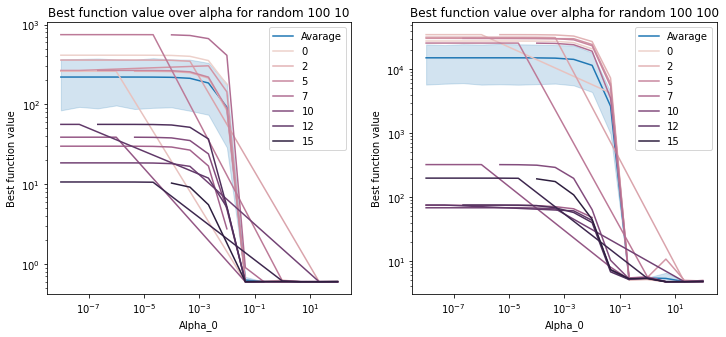

In [81]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, data) in zip(axs, experement_config.items()):
    plt.sca(ax)
    sns.lineplot(data['results']['alpha_0'], data['results']['best_func'], label='Avarage')
    sns.lineplot(data['results']['alpha_0'], data['results']['best_func'],
                 hue=np.arange(len(data['results']['alpha_0'])) // cnt_xs)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Best function value over alpha for {name}')
    plt.ylabel('Best function value')
    plt.xlabel('Alpha_0')
clear_output()
plt.show()

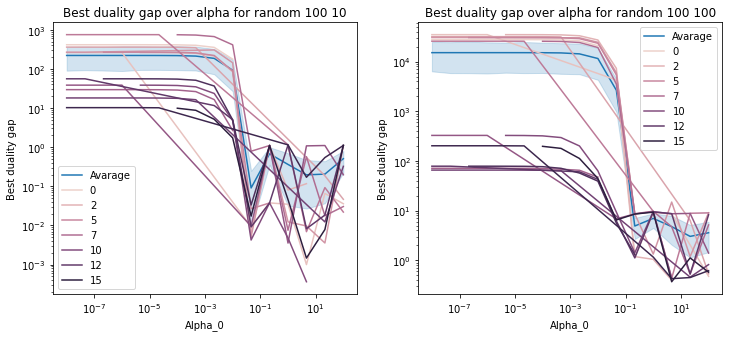

In [82]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, data) in zip(axs, experement_config.items()):
    plt.sca(ax)
    sns.lineplot(data['results']['alpha_0'], data['results']['best_duality_gap'], label='Avarage')
    sns.lineplot(data['results']['alpha_0'], data['results']['best_duality_gap'],
                 hue=np.arange(len(data['results']['alpha_0'])) // cnt_xs)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(f'Best duality gap over alpha for {name}')
    plt.ylabel('Best duality gap')
    plt.xlabel('Alpha_0')
clear_output()
plt.show()

### Результаты
- Качество сильно зависит от $alpha_0$
- Качество зависит от $x_0$
- Оптимальное значение $alpha_0$ зависит от $x_0$, но не сильно

## Эксперимент: Среднее число итераций линейного поиска в схеме Нестерова

### Подготовка и подсчёт

In [83]:
for name in experement_config:
    if 'results' in experement_config[name]:
        experement_config[name].pop('results')
    experement_config[name]['results'] = {
        'x_0': [],
        'x': [],
        'msg': [],
        'func': [],
        'time': [],
        'duality_gap': [],
        'best_duality_gap': [],
        'line_iter': [],
        'best_func': [],
    }

In [84]:
set_random_seed(107)
for name, data in experement_config.items():
    oracle = oracles.create_lasso_prox_oracle(
        data['data'], data['target'], 1.)
    x_0 = np.zeros(data['data'].shape[1])
    x, msg, history = opt.proximal_gradient_method(
        oracle, x_0, tolerance=0.3, trace=True, is_storing_iter=True)

    data['results']['x_0'] += [x_0]
    data['results']['x'] += [x]
    data['results']['msg'] += [msg]
    data['results']['best_duality_gap'] += [oracle.duality_gap(x)]
    data['results']['best_func'] += [oracle.func(x)]
    store_history(data['results'], history)

### Графики

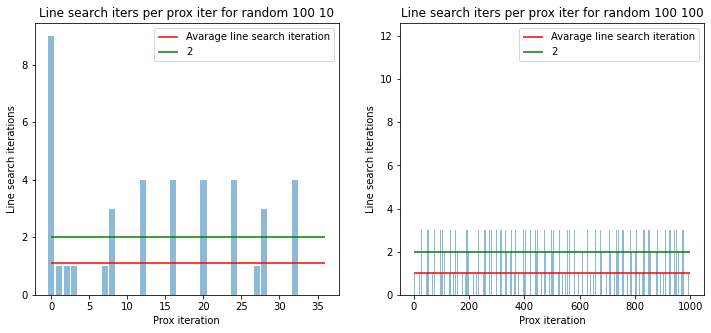

In [85]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, (name, data) in zip(axs, experement_config.items()):
    plt.sca(ax)
    plt.bar(np.arange(len(data['results']['line_iter'][0])),
            data['results']['line_iter'][0], alpha=0.5)
    plt.hlines(np.average(data['results']['line_iter'][0]),
               xmin=0, xmax=len(data['results']['line_iter'][0]),
               colors=['r'], label='Avarage line search iteration')
    plt.hlines(2, xmin=0, xmax=len(data['results']['line_iter'][0]), colors=['g'], label='2')
    plt.title(f'Line search iters per prox iter for {name}')
    plt.ylabel('Line search iterations')
    plt.xlabel('Prox iteration')
    plt.legend()
clear_output()
plt.show()

### Результаты
- Да, действительно среднее число итераций около (меньше 2)

## Эксперимент: Сравнение методов

### Подготовка и подсчёт

In [381]:
cnt = 6
ns = np.linspace(100, 1100, cnt, dtype=int)
default_n = 500
ms = np.linspace(10, 110, cnt, dtype=int)
default_m = 40
lambdas = np.logspace(-4, 2, cnt)
default_lamda = 20.

In [390]:
def get_method_config(method, oracle, kwargs):
    return {
        'oracle': oracle,
        'method': method,
        'kwargs': kwargs,
    }
    
experement_config = {
    'n': {},
    'm': {},
    'lambda': {},
}
set_random_seed(107)
for n in ns:
    experement_config['n'][n] = make_random_dataset(n, default_m)
for m in ms:
    experement_config['m'][m] = make_random_dataset(default_n, m)
for lambd in lambdas:
    experement_config['lambda'][lambd] = make_random_dataset(default_n, default_m)
for _, config_for_agg in experement_config.items():
    for name in config_for_agg:
        config_for_agg[name]['results'] = {}

methods_config = {
    'subgrad': get_method_config(opt.subgradient_method, oracles.create_lasso_nonsmooth_oracle,
                                 {'trace': True, 'alpha_0': 1e-1, 'max_iter': int(1e4), 'tolerance': 1e-1}),
    'prox': get_method_config(opt.proximal_gradient_method, oracles.create_lasso_prox_oracle,
                              {'trace': True, 'L_0': 1e-1, 'max_iter': int(1e4), 'tolerance': 1e-2}),
    'barrier': {'kwargs': {'lasso_duality_gap': oracles.lasso_duality_gap, 'trace': True, 'tolerance': 1e-2}},
}

In [391]:
for (name, config_per_element), (method_name, method_config) in product(experement_config.items(), methods_config.items()):
    for key, data in config_per_element.items():
        lambd = key if 'lambda' == name else default_lamda
        x_0 = np.zeros(data['data'].shape[1])
        if method_name == 'barrier':
            x, msg, history = opt.barrier_method_lasso(
                data['data'], data['target'], lambd, x_0,
                np.ones(data['data'].shape[1]), **method_config['kwargs'])
        else:
            oracle = method_config['oracle'](
                data['data'], data['target'], lambd)
            x, msg, history = method_config['method'](
                oracle, x_0, **method_config['kwargs'])

        data['results'][method_name] = history

In [392]:
def aggregate_by_dataset(data):
    result = {
        'subgrad': {},
        'prox': {},
        'barrier': {}
    }
    for key, results in data.items():
        for method, res in results['results'].items():
            result[method][key] = {}
            result[method][key]['time'] = res['time']
            result[method][key]['duality_gap'] = res['duality_gap']
    return result

In [393]:
aggregated = {
    'n': aggregate_by_dataset(experement_config['n']),
    'm': aggregate_by_dataset(experement_config['m']),
    'lambda': aggregate_by_dataset(experement_config['lambda'])
}

In [394]:
def plot_aggregated(aggregated_data, what='n'):
    aggregated_by = aggregated_data[what]
    _, axs = plt.subplots(3, 2, figsize=(12, 15))
    for i, (method, aggregated) in enumerate(aggregated_by.items()):
        for name, results in aggregated.items():
            if name > 50:
                name = int(name)
            if type(name) == np.float64:
                name = '%.4f' % name
            plt.sca(axs[i][0])
            plt.plot(results['time'], results['duality_gap'], label=f'{what} = {name}', alpha=.6)
            plt.legend()
            plt.yscale('log')
            plt.xlabel('Time')
            plt.ylabel('Duality gap')
            plt.title(f'Duality gap over time for {method}')

            plt.sca(axs[i][1])
            plt.plot(np.arange(len(results['duality_gap'])), results['duality_gap'], label=f'{what} = {name}', alpha=.6)
            plt.legend()
            plt.yscale('log')
            plt.xlabel('Iteration')
            plt.ylabel('Duality gap')
            plt.title(f'Duality gap over iter for {method}')

### Графики и результаты

#### Для n

- Как видно все методы зависят по скорости от n. В то время как по итерациям ситуация схожа (для каждого метода по отдельности).
- Для новых методов duality gap зависит от n.

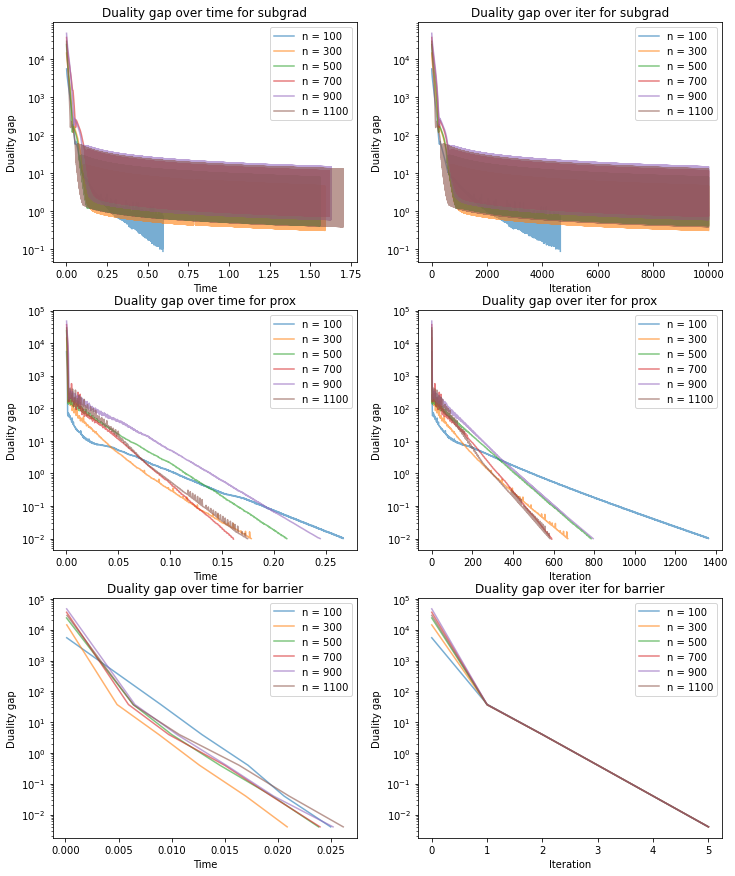

In [395]:
plot_aggregated(aggregated, 'n')

#### Для m

- Как видно все методы зависят по скорости и по итерациям от m.
- Также сходимость новых методов зависит от m, как и скорость сходимость барьеров.
- Для всех методов duality gap зависит от m.

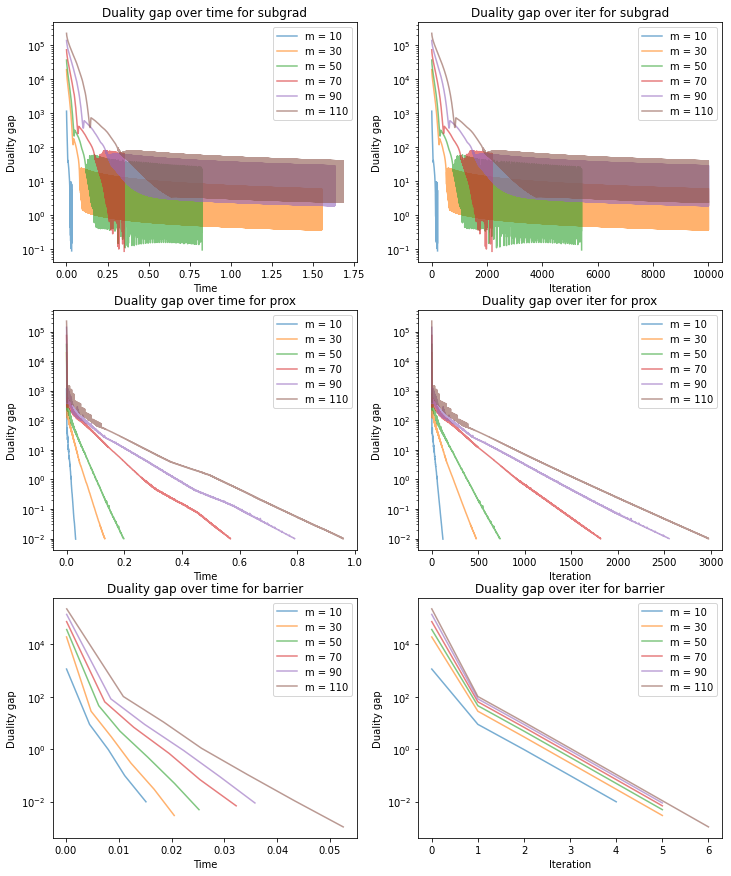

In [396]:
plot_aggregated(aggregated, 'm')

#### Для $\lambda$

- Как видно все методы зависят по скорости и по итерациям от $\lambda$.
- Скорость сходимости метода барьеров зависит от $\lambda$
- Для всех методов duality gap зависит от $\lambda$.

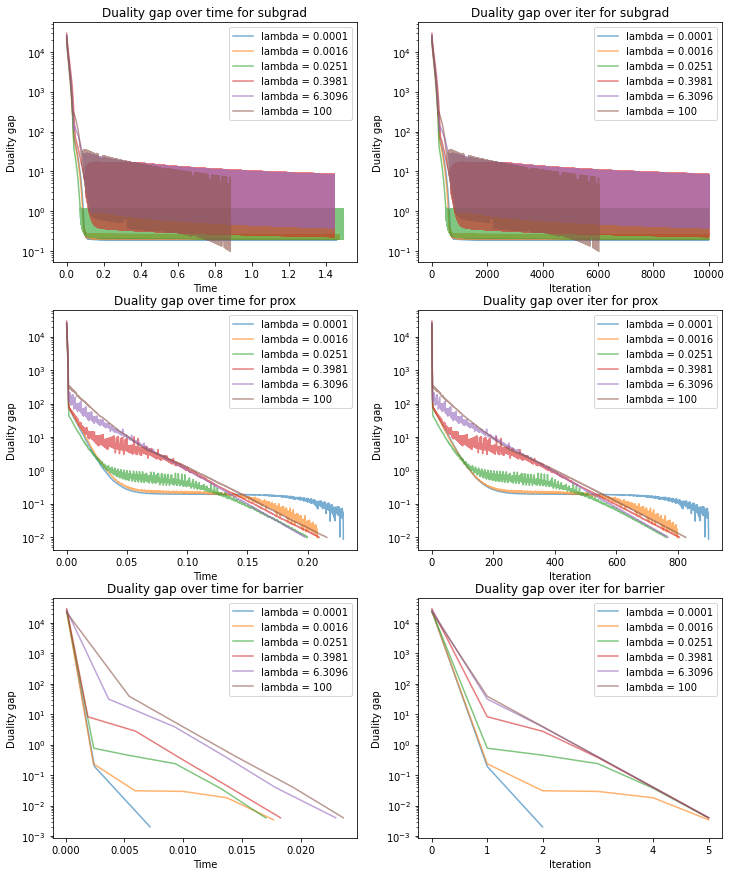

In [397]:
plot_aggregated(aggregated, 'lambda')

#### Общий вывод по моделям

- Как можно заметить субградиентный метод неточный и не может достичь необходимого результата даже при большом количестве итераций при этом скорость выполнения одной итерации гораздо выше, чем у метода барьеров.
- Прокимаксимальный метод сходиться при необходимых параметрах параметрах. и работает примерно в 10 раз дольше до сходимости, чем метод барьеров.
- Метод барьеров оказывается самым сильным среди 3 методов.

### Примечание

Мне кажется, что func и duality gap устроенны неправильно. Сравнивая с примером `sklearn.linear_model.Lasso`
$$
f(x) = \frac{1}{(2 * n)}||y - Xw||^2_2 + \alpha||w||_1\\
duality\_gap(x) = \frac{f(x) - f*}{n}
$$
Где $n$ - количество элементов в выборке. В таком случае методы будут сходиться сильно лучше.